In [1]:
import numpy as np
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split

In [2]:
def make_dataset(path):
    images=[]
    angry=0
    sad=0
    happy=0
    other=0
    for filename in os.listdir(path):
        new_path=os.path.join(path,filename)
        for img in os.listdir(new_path):
            image=cv2.imread(os.path.join(new_path,img))
            image=cv2.resize(image,(224,224))
            if image is not None:
                if filename=="Angry":
                    images.append(image)
                    angry+=1
                elif filename=="Sad":
                    images.append(image)
                    sad+=1
                elif filename=="happy":
                    images.append(image)
                    happy+=1
    Angry=np.zeros(angry)
    Happy=np.ones(happy)
    Sad=np.repeat(2,sad)
    label=np.hstack((Angry,Happy,Sad))
    label=tf.keras.utils.to_categorical(label,num_classes=3)
    return images,label

In [3]:
images,label=make_dataset("Master Folder")
images=np.array(images)
print(images.shape,label.shape)

(8556, 224, 224, 3) (8556, 3)


In [4]:
train_X,trail_X,train_label,trail_label=train_test_split(images,label,test_size=0.2,random_state=42,shuffle=True,stratify=label)
validation_X,test_X,validation_label,test_label=train_test_split(trail_X,trail_label,test_size=0.7,random_state=42,shuffle=True,stratify=trail_label)

In [5]:
def preprocess_image(images):
    image=tf.cast(images,tf.float32)/255.0
    return image

In [6]:
train_X=preprocess_image(train_X)
validation_X=preprocess_image(validation_X)
test_X=preprocess_image(test_X)

In [7]:
callbacks=[EarlyStopping(monitor = "val_loss", patience = 5, 
            restore_best_weights = True, mode='min')
            ,ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
            ]

In [12]:
def model_build(inputs):
    
    feature_extract=tf.keras.applications.MobileNetV2(input_shape=(224,224,3),weights="imagenet",include_top=False)
    feature_extract.trainable=False
    x=feature_extract(inputs,training=False)
    x=tf.keras.layers.AveragePooling2D((3,3))(x)
    x=tf.keras.layers.Flatten()(x)
    x=tf.keras.layers.Dense(128,activation='relu')(x)
    x=tf.keras.layers.Dropout(0.5)(x)
    x=tf.keras.layers.Dense(64,activation='relu')(x)
    x=tf.keras.layers.Dropout(0.5)(x)
    x=tf.keras.layers.Dense(32,activation='relu')(x)
    x=tf.keras.layers.Dropout(0.5)(x)
    x=tf.keras.layers.Dense(3,activation='softmax')(x)
    
    return x

In [13]:
def define_compile_model():
    inputs=tf.keras.layers.Input(shape=(224,224,3))
    output=model_build(inputs)
    model=tf.keras.Model(inputs=inputs,outputs=output)
    model.compile(optimizer='adamax',loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [14]:
model=define_compile_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 average_pooling2d_1 (Avera  (None, 2, 2, 1280)        0         
 gePooling2D)                                                    
                                                                 
 flatten_1 (Flatten)         (None, 5120)              0         
                                                                 
 dropout_4 (Dropout)         (None, 5120)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               1310

In [23]:
epochs=10
batch_size=16
history = model.fit(train_X, train_label,batch_size=batch_size,epochs=epochs,verbose=1,callbacks=callbacks
                    ,validation_data=(validation_X,validation_label)
                    )

Epoch 1/10
428/428 [==============================] - 235s 547ms/step - loss: 0.1923 - accuracy: 0.9299 - val_loss: 0.1561 - val_accuracy: 0.9552 - lr: 2.0000e-04
Epoch 2/10
428/428 [==============================] - 231s 541ms/step - loss: 0.1999 - accuracy: 0.9274 - val_loss: 0.1596 - val_accuracy: 0.9532 - lr: 2.0000e-04
Epoch 3/10
428/428 [==============================] - 224s 523ms/step - loss: 0.1878 - accuracy: 0.9281 - val_loss: 0.1550 - val_accuracy: 0.9571 - lr: 2.0000e-04
Epoch 4/10
428/428 [==============================] - 218s 509ms/step - loss: 0.1722 - accuracy: 0.9344 - val_loss: 0.1494 - val_accuracy: 0.9532 - lr: 2.0000e-04
Epoch 5/10
428/428 [==============================] - 220s 514ms/step - loss: 0.1868 - accuracy: 0.9340 - val_loss: 0.1480 - val_accuracy: 0.9591 - lr: 2.0000e-04
Epoch 6/10
428/428 [==============================] - 223s 521ms/step - loss: 0.1849 - accuracy: 0.9307 - val_loss: 0.1554 - val_accuracy: 0.9552 - lr: 2.0000e-04
Epoch 7/10
428/428 [==

KeyboardInterrupt: 

In [17]:
model.evaluate(train_X,train_label)

214/214 [==============================] - 202s 939ms/step - loss: 0.0311 - accuracy: 0.9969


[0.03110995516180992, 0.9969316124916077]

In [18]:
model.evaluate(test_X,test_label)

38/38 [==============================] - 38s 972ms/step - loss: 0.1784 - accuracy: 0.9441


[0.17843465507030487, 0.9441201090812683]

In [19]:
def detect(path):
    trail_image=cv2.imread(path)
    trail_image=cv2.cvtColor(trail_image,cv2.COLOR_BGR2RGB)
    trail_image=cv2.resize(trail_image,(224,224))
    trail_image=trail_image.reshape(1,224,224,3)
    trail_image_prediction=model.predict(trail_image)
    trail_image_prediction=np.argmax(trail_image_prediction)
    if trail_image_prediction==0:
        prediction="Angry"
    elif trail_image_prediction==1:
        prediction="Sad"
    else:
        prediction="Happy"
    plt.title(prediction)
    plt.imshow(trail_image[0])

1/1 [==============================] - 3s 3s/step


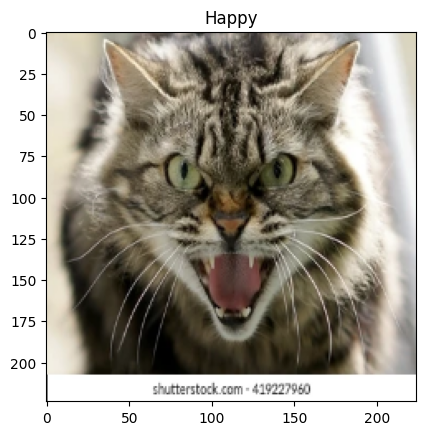

In [20]:
detect("C:\\Users\\Dell\\Downloads\\angry1.jpg")

1/1 [==============================] - 0s 101ms/step


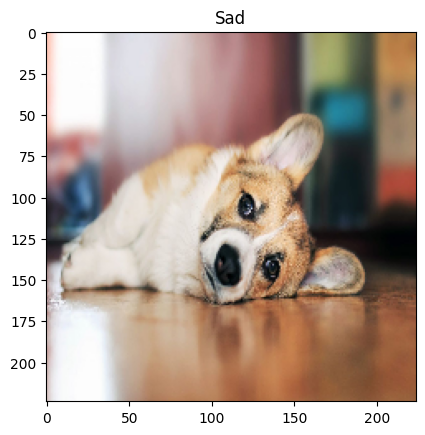

In [21]:
detect("C:\\Users\\Dell\\Downloads\\sad1.jpg")

1/1 [==============================] - 0s 95ms/step


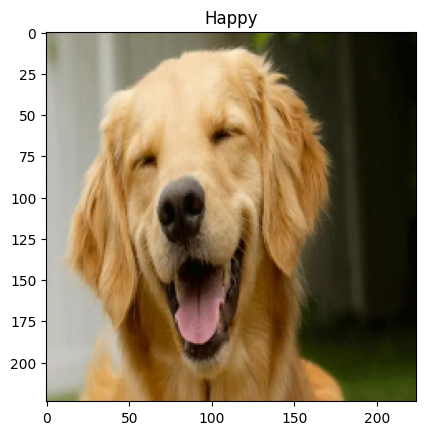

In [22]:
detect("C:\\Users\\Dell\\Downloads\\happy-pup-1.png")

In [ ]:
# from keras.preprocessing.image import ImageDataGenerator
# datagen = ImageDataGenerator(
#         rotation_range=20,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         horizontal_flip=True,
#         vertical_flip=True,
#         fill_mode='nearest')

In [ ]:
# master="Master Folder"
# for file in os.listdir(master):
#     path=os.path.join(master,file)
#     itr=0
#     for img in os.listdir(path):
#         image=cv2.imread(os.path.join(path,img))
#         image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
#         image=np.array(image)
#         image=image.reshape((1,)+image.shape)
#         total=0
#         for batch in datagen.flow(image,batch_size=1,save_to_dir=path,save_prefix=file,save_format='jpg'):
#             total+=1
#             if total>10:
#                 break